# Hydra Calcium Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from visualizer.vlib import vplot

## 1. Intracellular Models

### 1.1 Slow Cell

An intracellular model where the major source of \[Ca$^{2+}$\] is IP3-triggered calcium release from ER, following [Hofer et al. 2002](https://www.ncbi.nlm.nih.gov/pubmed/12077182).

In [2]:
from single.hofer_cell import HoferCell

#### 1.1.1 Single Stimulation

In [86]:
hofer_model = HoferCell(T=200)
sol = hofer_model.step()
c, s, r, ip = sol[:,0], sol[:,1], sol[:,2], sol[:,3]

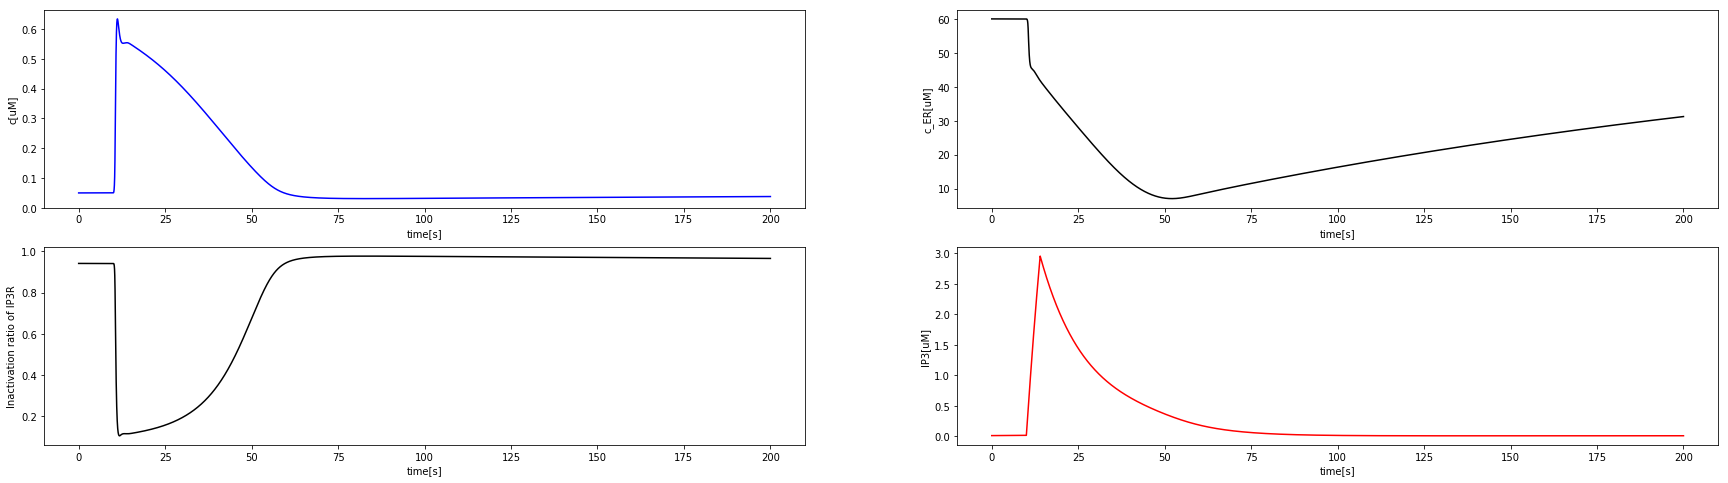

In [88]:
# Plot dynamical variables
vplot((c,s,r,ip), hofer_model, 
      tmax = 200,
      ylabels = ['c[uM]', 'c_ER[uM]', 'Inactivation ratio of IP3R',  'IP3[uM]'],
      colors=['b', 'k', 'k', 'r'],
      size = (30,8))

In [89]:
# Plot calium currents
irel = hofer_model.i_rel(c, s, ip, r)
iserca = hofer_model.i_serca(c)
ipmca = hofer_model.i_pmca(c)
ileak = hofer_model.i_leak(c, s)
iout = hofer_model.i_out(c)
iin = hofer_model.i_in(c, ip)

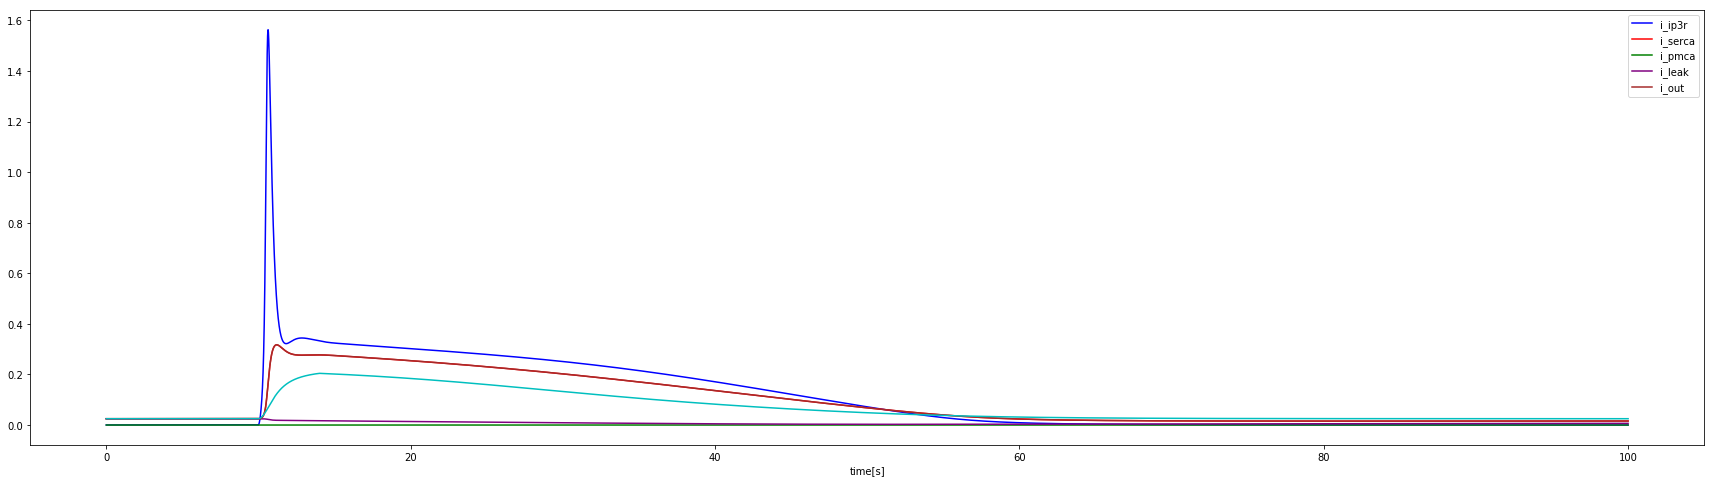

In [90]:
vplot((irel, iserca, ipmca, ileak, iout, iin), 
      hofer_model,
      colors = ['b', 'r', 'g', 'purple', 'brown', 'c'],
      separate = False,
      legend = ['i_ip3r', 'i_serca', 'i_pmca', 'i_leak', 'i_out'],
      size = (30, 8))

#### 1.1.2 Multiple Stimulation

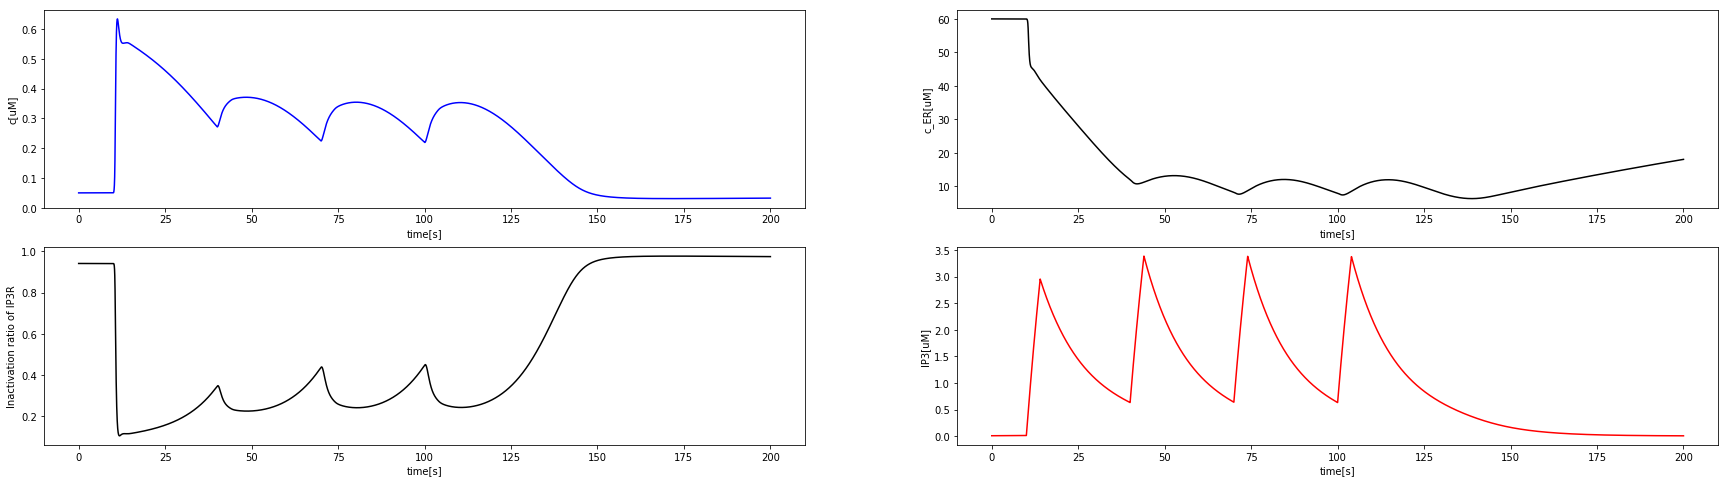

In [93]:
sol = hofer_model.step([10, 40, 70, 100])
c, s, r, ip = sol[:,0], sol[:,1], sol[:,2], sol[:,3]

vplot((c,s,r,ip), hofer_model, 
      tmax = 200,
      ylabels = ['c[uM]', 'c_ER[uM]', 'Inactivation ratio of IP3R',  'IP3[uM]'],
      colors=['b', 'k', 'k', 'r'],
      size = (30,8))

### 1.2 Fast Cell
An intracellular model where the major source of  \[Ca$^{2+}$\] is the influxes through voltage-gated calcium channels (L-type and T-type) from extracellular space, following [Mahapatra et al. 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0200712) and [Yochum et al., 2016](https://www.sciencedirect.com/science/article/pii/S0010482516301925).

In [94]:
from single.fast_cell import FastCell

#### 1.2.1 Single Stimulation

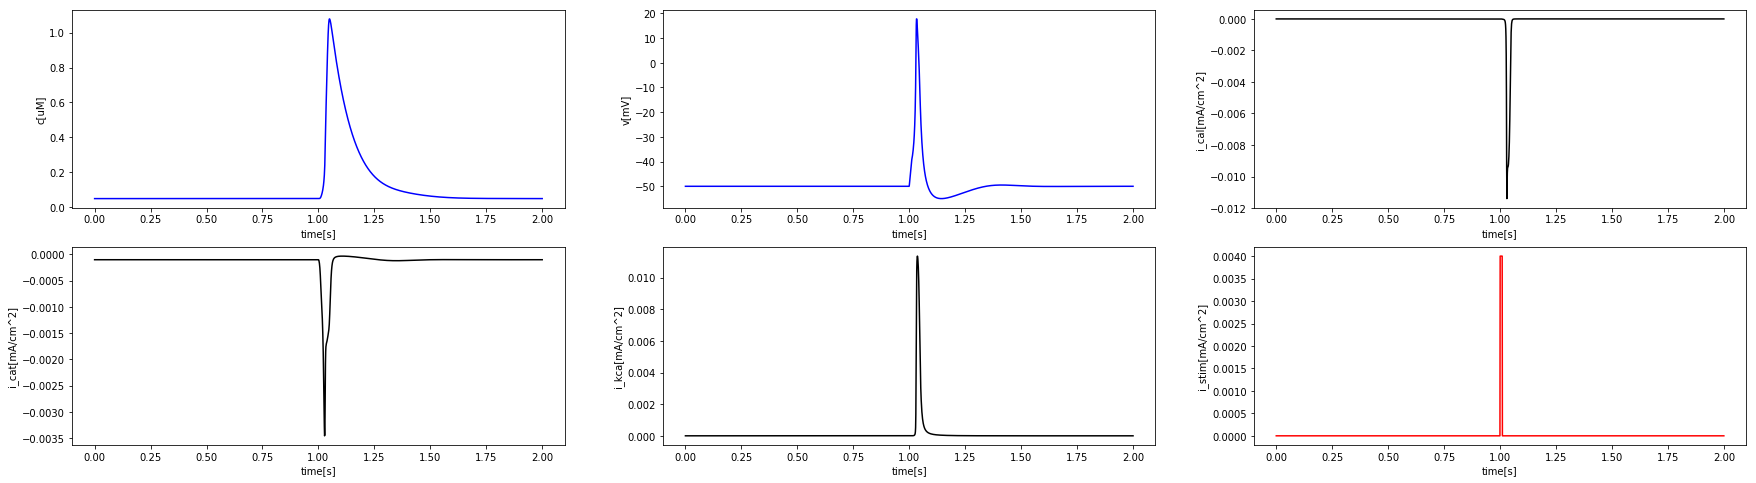

In [95]:
fast_model = FastCell(2)
sol = fast_model.step([1])
c,v,n,hv,hc,x,z,p,q,bx,cx = (sol[:,0], sol[:,1], sol[:,2], sol[:,3], 
                             sol[:,4], sol[:,5], sol[:,6], sol[:,7],
                             sol[:,8], sol[:,9], sol[:,10])

ical = fast_model.i_cal(v, n , hv, hc)
icat = fast_model.i_cat(v, bx, cx)
ikca = fast_model.i_kca(v, c)
istim = [0.004 * fast_model.stim_v(t, [1]) for t in fast_model.time]

vplot((c, v, ical, icat, ikca, istim), fast_model, 
      ylabels = ['c[uM]', 'v[mV]', 'i_cal[mA/cm^2]', 'i_cat[mA/cm^2]', 'i_kca[mA/cm^2]', 'i_stim[mA/cm^2]'],
      colors = ['b', 'b', 'k', 'k', 'k', 'r'],
     size = (30, 8))

#### 1.2.2 Multiple Stimulation

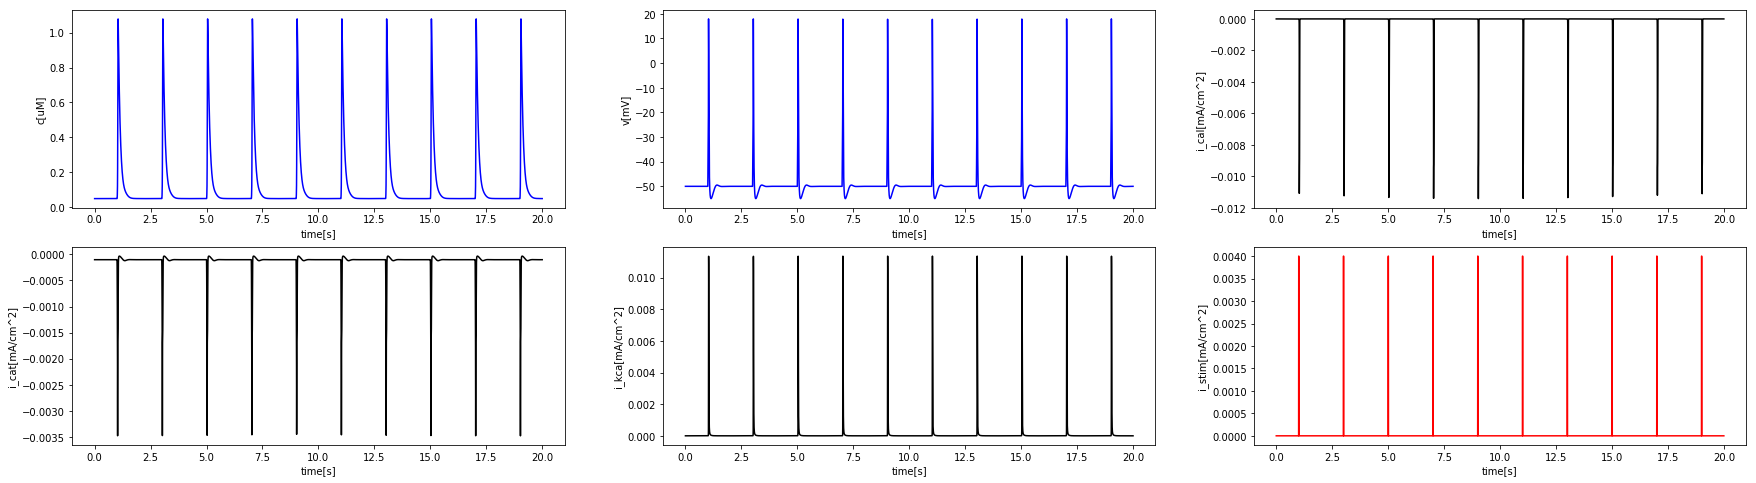

In [96]:
fast_model = FastCell(20)
sol = fast_model.step([1,3,5,7,9,11,13,15,17,19])
c,v,n,hv,hc,x,z,p,q,bx,cx = (sol[:,0], sol[:,1], sol[:,2], sol[:,3], 
                             sol[:,4], sol[:,5], sol[:,6], sol[:,7],
                             sol[:,8], sol[:,9], sol[:,10])

ical = fast_model.i_cal(v, n , hv, hc)
icat = fast_model.i_cat(v, bx, cx)
ikca = fast_model.i_kca(v, c)
istim = [0.004 * fast_model.stim_v(t, [1,3,5,7,9,11,13,15,17,19]) for t in fast_model.time]

vplot((c, v, ical, icat, ikca, istim), fast_model, 
      ylabels = ['c[uM]', 'v[mV]', 'i_cal[mA/cm^2]', 'i_cat[mA/cm^2]', 'i_kca[mA/cm^2]', 'i_stim[mA/cm^2]'],
      colors = ['b', 'b', 'k', 'k', 'k', 'r'],
     size = (30, 8))

### 1.3 Combined Single Cell

An intracellualr model combining the models in 1.1 and 1.2 -- two different stimulations trigger two different types of calcium transients

In [97]:
from single.cell import Cell
from force.maggio_force_encoder import MHMEncoder

#### 1.3.1 Non-regenerative Dynamics (Without PLC-delta)

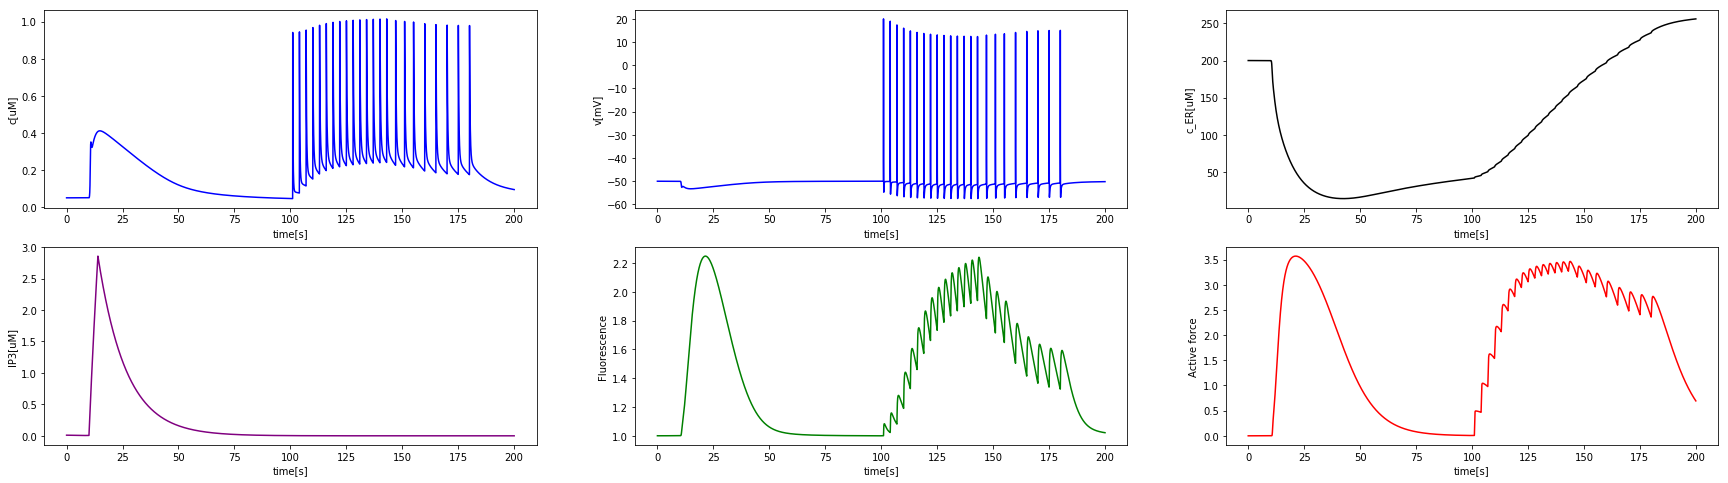

In [100]:
single_model = Cell(T=200, k2 = 0.05, s0 = 200, d = 10e-4, v7 = 0)
'''
T: Total time
k2: Rate constant of IP3R
s0: Initial ca concentration in ER
d: Volume/Surface area of cell
v7: Rate constant of PLC-delta
'''

sol = single_model.step([101,104,107,110,113,116,119,122,
                         125,128,131,134,137,140,143,
                         147,151,155,160,165,170,175,180], [10])
# sol = single_model.step([], [10, 40, 70, 100])
c, s, r, ip, v, g, c1g, c2g, c3g, c4g = (sol[:,0], sol[:,1], sol[:,2], 
                                         sol[:,3], sol[:,4], sol[:,10],
                                         sol[:,11], sol[:,12], sol[:,13],
                                         sol[:,14])

fluo = single_model.f_total(g, c1g, c2g, c3g, c4g)
force_encoder = MHMEncoder(c)
force = force_encoder.step()

vplot((c,v,s,ip,fluo,force),
      single_model,
      tmax = 200,
      ylabels = ['c[uM]',  'v[mV]', 'c_ER[uM]', 'IP3[uM]', 
                'Fluorescence',  'Active force'],
      colors = ['blue', 'blue', 'k', 'purple', 'green', 'red'],
      size = (30,8))

#### 1.3.2 Regenerative Dynamics (With PLC-delta)

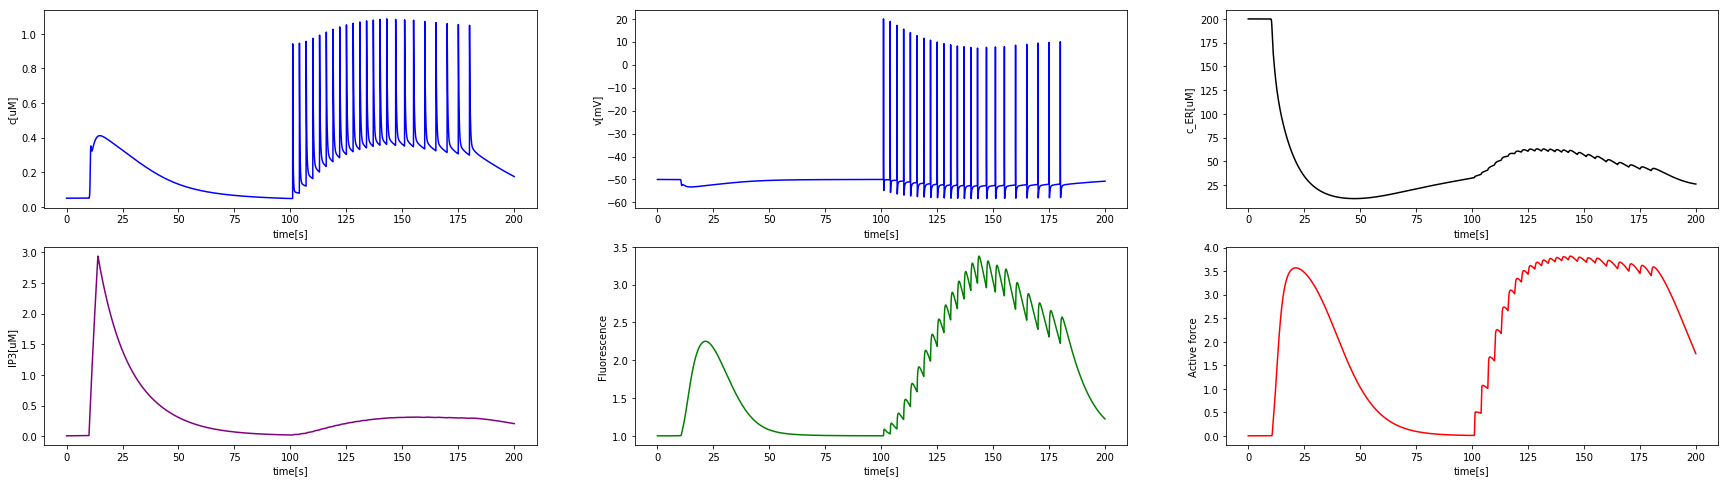

In [12]:
single_model = Cell(T=200, k2 = 0.05, s0 = 200, d = 10e-4, v7 = 0.04)
'''
T: Total time
k2: Rate constant of IP3R
s0: Initial ca concentration in ER
d: Volume/Surface area of cell
v7: Rate constant of PLC-delta
'''

sol = single_model.step([101,104,107,110,113,116,119,122,
                         125,128,131,134,137,140,143,
                         147,151,155,160,165,170,175,180], [10])
# sol = single_model.step([], [10, 100])
c, s, r, ip, v, g, c1g, c2g, c3g, c4g = (sol[:,0], sol[:,1], sol[:,2], 
                                         sol[:,3], sol[:,4], sol[:,10],
                                         sol[:,11], sol[:,12], sol[:,13],
                                         sol[:,14])

fluo = single_model.f_total(g, c1g, c2g, c3g, c4g)
force_encoder = MHMEncoder(c)
force = force_encoder.step()

vplot((c,v,s,ip,fluo,force),
      single_model,
      tmax = 200,
      ylabels = ['c[uM]',  'v[mV]', 'c_ER[uM]', 'IP3[uM]', 
                'Fluorescence',  'Active force'],
      colors = ['blue', 'blue', 'k', 'purple', 'green', 'red'],
      size = (30,8))

## 2. Multicellular Models

### 2.1 1D Cell Chain

In [70]:
from d1.chain import Chain
from visualizer.vlib import save_pattern
from matplotlib.ticker import MaxNLocator

#### 2.1.1 Passive Wave
Corresponding to the intracellular model in 1.3.1

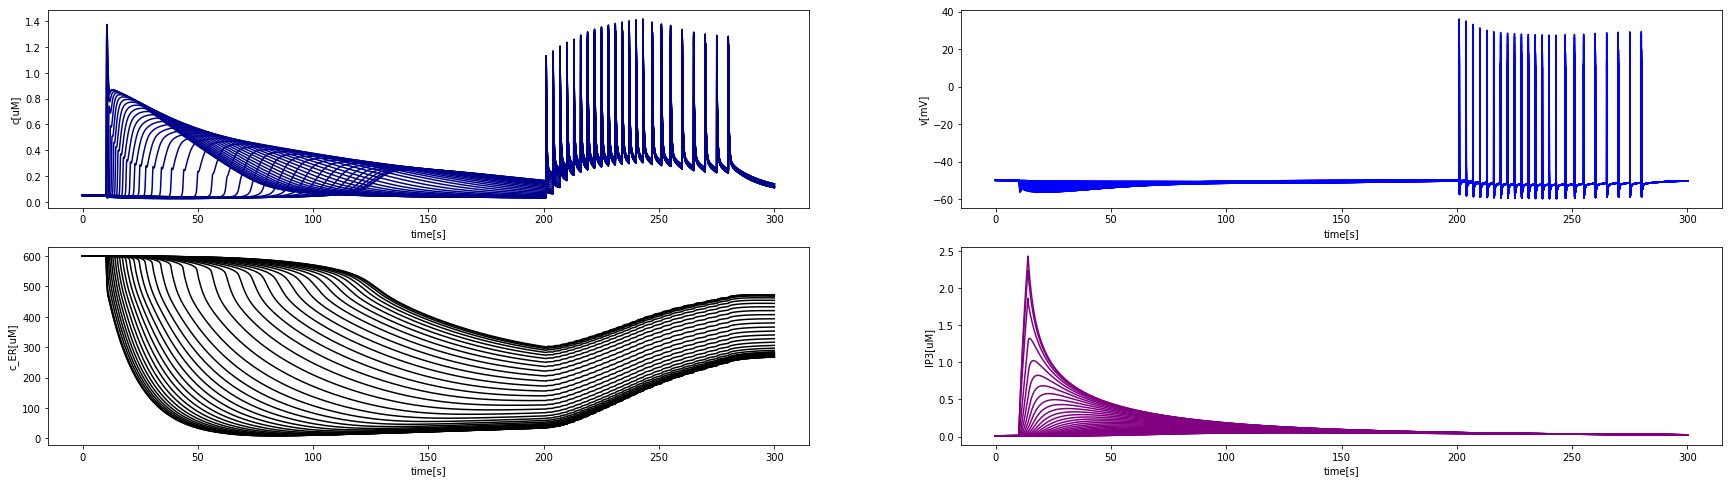

In [63]:
chain_model = Chain(num = 40, T = 300, k2 = 0.1, s0 = 600, d = 10e-4, v7 = 0, k9 = 0.01)
# k9: The degration rate of IP3

sol = chain_model.step([201,204,207,210,213,216,219,222,
                         225,228,231,234,237,240,243,
                         247,251,255,260,265,270,275,280], [10])

n_cel = 40
c, s, r, ip, v = (sol[:,0:n_cel], sol[:,n_cel:2*n_cel], 
                  sol[:,2*n_cel:3*n_cel], sol[:,3*n_cel:4*n_cel], sol[:, 4*n_cel:5*n_cel])

vplot((c,v,s,ip),
      chain_model,
      tmax = 300,
      ylabels = ['c[uM]',  'v[mV]', 'c_ER[uM]', 'IP3[uM]'],
      colors = ['darkblue', 'blue', 'k', 'purple'],
      size = (30,8))

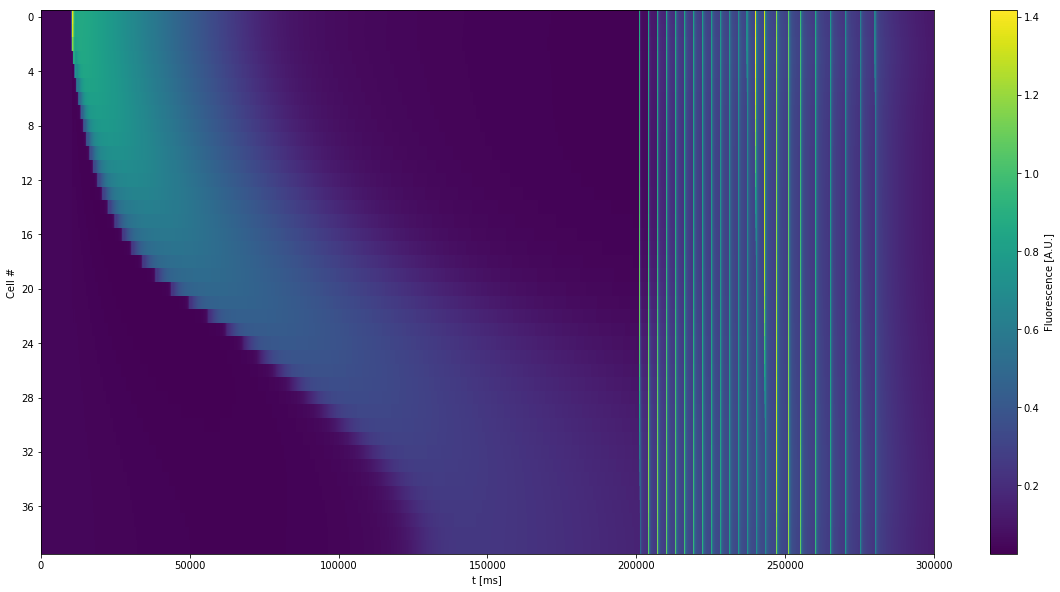

In [78]:
save_pattern(c, None, save = False, size = (20, 10))

#### 2.1.2 Active Wave

Corresponding to the intracellular model in 1.3.2

In [60]:
chain_model = Chain(num = 40, T = 300, k2 = 0.05, s0 = 400, d = 10e-4, v7 = 0.04, k9 = 0.04)

sol2 = chain_model.step([201,204,207,210,213,216,219,222,
                         225,228,231,234,237,240,243,
                         247,251,255,260,265,270,275,280], [10])

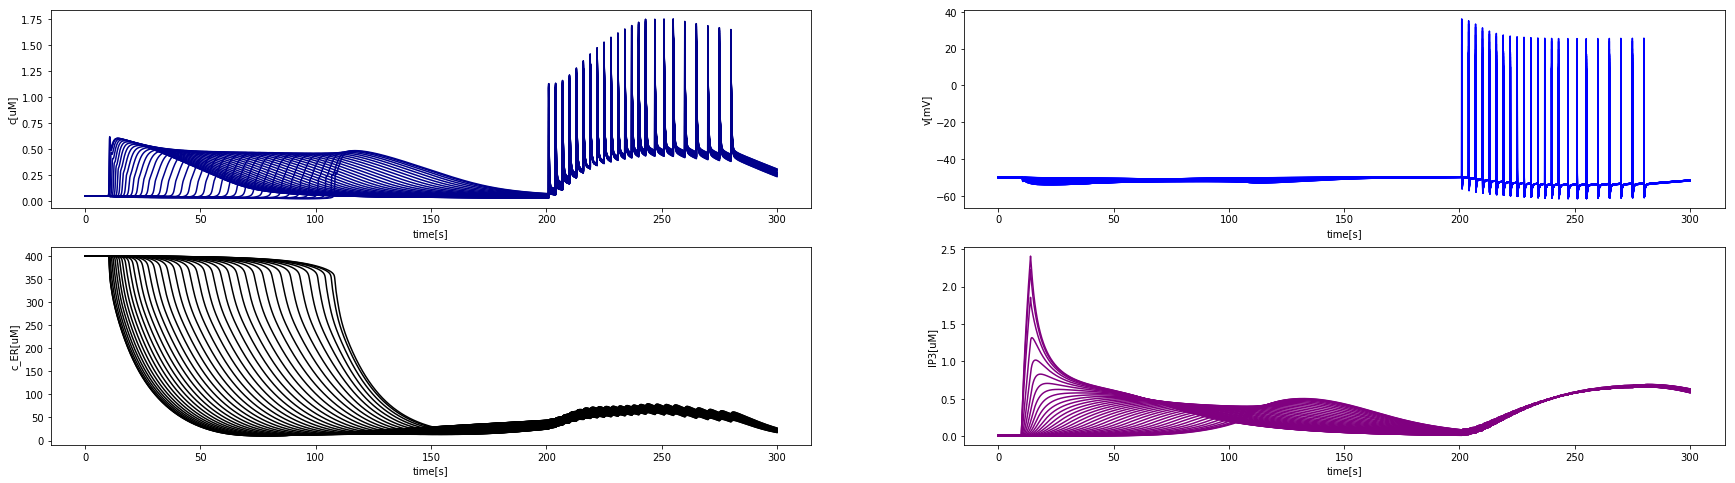

In [79]:
n_cel = 40
c, s, r, ip, v = (sol2[:,0:n_cel], sol2[:,n_cel:2*n_cel], 
                  sol2[:,2*n_cel:3*n_cel], sol2[:,3*n_cel:4*n_cel], sol2[:, 4*n_cel:5*n_cel])

vplot((c,v,s,ip),
      chain_model,
      tmax = 300,
      ylabels = ['c[uM]',  'v[mV]', 'c_ER[uM]', 'IP3[uM]'],
      colors = ['darkblue', 'blue', 'k', 'purple'],
      size = (30,8))

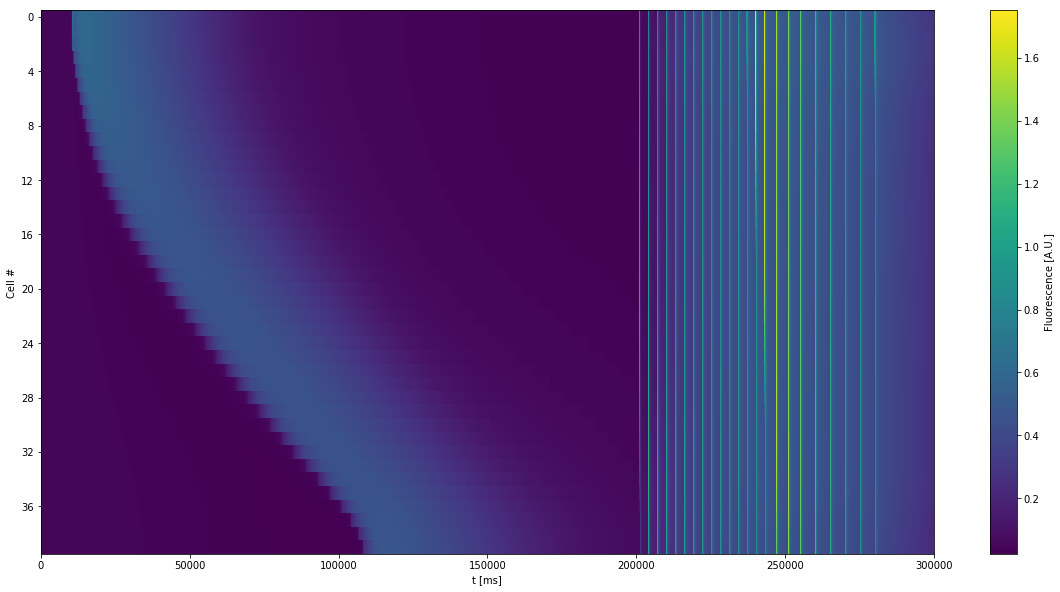

In [80]:
save_pattern(c, None, save = False, size = (20, 10))

### 2.2 2D Cell Grid